In [1]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.all_utils import to_categorical
#Keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [2]:
metadata = pd.read_csv('deepglobe/metadata.csv')
metadata.head()

,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png


In [3]:
metadata = metadata[metadata['split']=='train']

In [4]:
len(metadata)

6226

In [5]:
metadata.isnull().sum()

image_id          0
split             0
sat_image_path    0
mask_path         0
dtype: int64

In [6]:
metadata['sat_image_path'][0]

'train/100034_sat.jpg'

In [7]:
images = []
masks = []
for i in tqdm(range(6226)):
    path='deepglobe/'
    image = plt.imread(path+metadata['sat_image_path'][i])
    mask = plt.imread(path+metadata['mask_path'][i])
    image = cv2.resize(image,(128,128),interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mask,(128,128),interpolation=cv2.INTER_CUBIC)
    images.append(image)
    masks.append(mask)

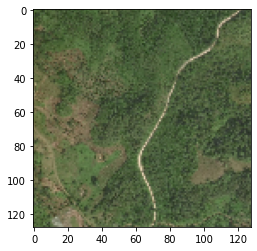

In [8]:
plt.imshow(images[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


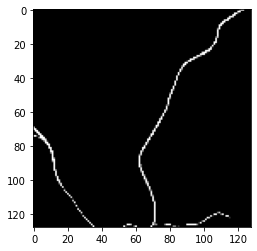

In [9]:
plt.imshow(masks[0])

### Binarization of masks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


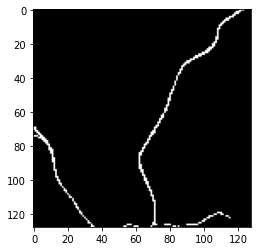

In [10]:
th, im_th = cv2.threshold(masks[0], 0, 255, cv2.THRESH_BINARY)
plt.imshow(im_th)

In [11]:
bin_masks = []
for mask in tqdm(masks):
    th,im_th = cv2.threshold(mask,0,255,cv2.THRESH_BINARY)
    bin_masks.append(im_th)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


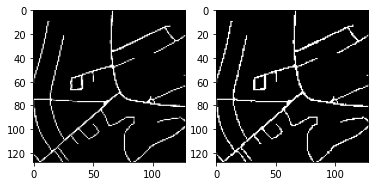

In [12]:
ind = np.random.randint(6226)
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(masks[ind])
fig.add_subplot(1,2,2)
plt.imshow(bin_masks[ind])
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(images,masks,test_size=0.2,random_state=42)

In [14]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

### defining functions for unet model

In [15]:
from keras.layers import BatchNormalization,Activation
def conv2dblocks(inputlayer,nfilters,ksize=3,norm=True):
    
    x = Conv2D(filters = nfilters,kernel_size=(ksize,ksize),padding='same')(inputlayer)
    if norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = nfilters,kernel_size=(ksize,ksize),padding='same')(x)
    if norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [16]:
from keras.layers import Conv2DTranspose,concatenate
import tensorflow as tf
def unet(inputlayer,nfilters,dropouts,norm=True):
    
    c1 = conv2dblocks(inputlayer,nfilters,ksize=3,norm=norm)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropouts)(p1)
    
    c2 = conv2dblocks(inputlayer,nfilters*2,ksize=3,norm=norm)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(dropouts)(p2)
    
    c3 = conv2dblocks(inputlayer,nfilters*4,ksize=3,norm=norm)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(dropouts)(p3)
    
    c4 = conv2dblocks(inputlayer,nfilters*8,ksize=3,norm=norm)
    p4 = MaxPooling2D((2,2))(c4)
    p4 = Dropout(dropouts)(p4)
    
    c5 = conv2dblocks(inputlayer,nfilters*8,ksize=3,norm=norm)
    
    u6 = Conv2DTranspose(nfilters*8, (3, 3), strides = (1, 1), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropouts)(u6)
    c6 = conv2dblocks(u6, nfilters*8, ksize = 3, norm = norm)
    
    u7 = Conv2DTranspose(nfilters*4, (3, 3), strides = (1, 1), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropouts)(u7)
    c7 = conv2dblocks(u7, nfilters*4, ksize = 3, norm = norm)
    
    u8 = Conv2DTranspose(nfilters*2, (3, 3), strides = (1, 1), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropouts)(u8)
    c8 = conv2dblocks(u8, nfilters*2, ksi ze = 3, norm = norm)
    
    u9 = Conv2DTranspose(nfilters*1, (3, 3), strides = (1, 1), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropouts)(u9)
    c9 = conv2dblocks(u9, nfilters*1, ksize = 3, norm = norm)
    
    output = Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputlayer], outputs = [output])
    return model

### Training U-Net model

In [17]:
from keras.layers import Input
inputs = Input((128,128,3))
Unet = unet(inputs,nfilters=16,dropouts=0.2)
Unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 128, 128, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 128, 128, 12  512        ['conv2d_8[0][0]']               
 rmalization)                   8)                                                            

In [18]:
Unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [19]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor = 'val_accuracy',
    patience=3,
    mode='max',
    restore_best_weights=True
)

In [21]:
history = Unet.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),callbacks=[callback],verbose=1)

Epoch 1/10
156/156 [==============================] - 4451s 29s/step - loss: 0.3289 - accuracy: 0.4160 - val_loss: 0.2694 - val_accuracy: 0.6130
Epoch 2/10
156/156 [==============================] - 4436s 28s/step - loss: 0.1772 - accuracy: 0.4052 - val_loss: 0.1650 - val_accuracy: 0.3885
Epoch 3/10
156/156 [==============================] - 4431s 28s/step - loss: 0.1419 - accuracy: 0.3951 - val_loss: 0.1503 - val_accuracy: 0.2108
Epoch 4/10
156/156 [==============================] - 4476s 29s/step - loss: 0.1285 - accuracy: 0.3827 - val_loss: 0.1374 - val_accuracy: 0.5711


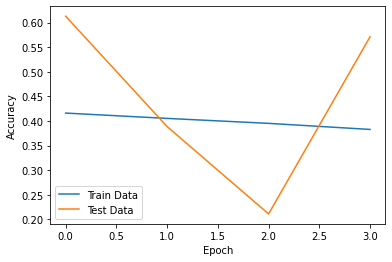

In [22]:
plt.plot(history.history['accuracy'], label='Train Data')
plt.plot(history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

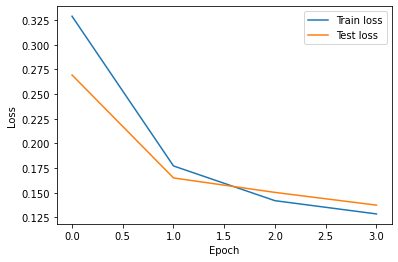

In [24]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [26]:
Unet.save("unet-61.h5")

In [29]:
Unet.save_weights("unet-61-weights.h5")

In [28]:
X_test.shape

(1246, 128, 128, 3)

In [32]:
preds = Unet.predict(X_test,verbose=1)

39/39 [==============================] - 276s 7s/step


In [35]:
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_test,preds)
miou.result().numpy()


0.4405648

In [37]:
bin_acc = tf.keras.metrics.BinaryAccuracy()
bin_acc.update_state(y_test,preds)
bin_acc.result().numpy()

0.9305018

In [42]:
from tensorflow.keras import backend as K
smooth=100
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

In [44]:
dice_coef(y_test,preds).numpy()

0.082312346

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


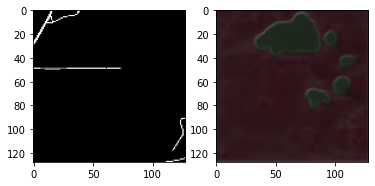

In [50]:
ind = np.random.randint(1246)
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(y_test[ind])
fig.add_subplot(1,2,2)
plt.imshow(preds[ind])
plt.show()

In [51]:
pred_bin_masks = []
for mask in tqdm(preds):
    th,im_th = cv2.threshold(mask,0,255,cv2.THRESH_BINARY)
    pred_bin_masks.append(im_th)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


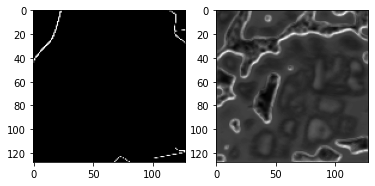

In [62]:
ind = np.random.randint(1246)
fig = plt.figure()
fig.add_subplot(1,2,1)
grayimg = preds[ind,:,:,0]*0.2989+preds[ind,:,:,1]*0.5870+preds[ind,:,:,2]*0.1140
plt.imshow(y_test[ind])
fig.add_subplot(1,2,2)
plt.imshow(grayimg,cmap='gray')
plt.show()